In [1]:
# pip install stop-words

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import re
import nltk
import scipy.stats

# from nltk import FreqDist
from collections import Counter
from wordcloud import WordCloud
from wordcloud import STOPWORDS
from stop_words import get_stop_words
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import hstack
from sklearn import metrics
from sklearn import tree
from sklearn import svm

In [3]:
def combine_data(folder_path):
    data_frames = []

    for file_name in os.listdir(folder_path):
        if file_name.endswith(".txt"):
            file_path = os.path.join(folder_path, file_name)
            df = pd.read_csv(file_path, sep='\t', names=["ID", "Text", "Emotion", "Intensity"])
            data_frames.append(df)

    combined_data = pd.concat(data_frames, ignore_index=True)
    return combined_data

In [4]:
def text_cleaning(data_frame):

    # Apply regular expression directly to the 'text' column
    data_frame['Text'] = data_frame['Text'].apply(lambda x: re.sub(r'@[A-Za-z0-9_]+|https?://[A-Za-z0-9./]+|[0-9]+', '', x, flags=re.MULTILINE))
    
    # Lowercase and tokenize
    data_frame['Text']  = data_frame['Text'].apply(lambda x: word_tokenize(x.lower()))
    
    # Remove stopwords
    data_frame['Text']  = data_frame['Text'].apply(lambda x: [w for w in x if w not in stop_words])
    
    # Join the tokens back into a string
    data_frame['Text'] = data_frame['Text'].apply(lambda x: ' '.join(x).strip())
    
    return data_frame

In [5]:
#define function to get the scores
def get_score(y_test, y_pred, name):
    print(name + '\n')
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
    print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    print('-------------------------------------------------------------------------------')

In [6]:
def predict_emotion_intensity(model, vectorizer, emotion_df, actual_column_name):
    X_test = combined_vectorizer.transform(emotion_df['Text'])
    Y_actual = emotion_df[actual_column_name]
    Y_predicted = model.predict(X_test)
    return Y_actual, Y_predicted

In [7]:
def evaluate(predicted, actual):
    # Lists storing actual and prediction scores
    actual_scores = []  
    predicted_scores = []

    # Lists storing actual and prediction scores where actual score >= 0.5
    actual_scores_range_05_1 = []
    predicted_scores_range_05_1 = []
        
    for p in predicted:
        predicted_scores.append(p)
        
    for a in actual:
        actual_scores.append(a)

    for i in range(len(actual_scores)):
        if actual_scores[i] >= 0.5:
            actual_scores_range_05_1.append(actual_scores[i])
            predicted_scores_range_05_1.append(predicted_scores[i])

    # Return zero correlation if predictions are constant
    if np.std(predicted_scores) == 0 or np.std(actual_scores) == 0:
        return (0, 0, 0, 0)

    pearson_corr = scipy.stats.pearsonr(predicted_scores, actual_scores)[0]                                     
    pearson_corr_range_05_1 = scipy.stats.pearsonr(predicted_scores_range_05_1, actual_scores_range_05_1)[0]                                           
    
    return (pearson_corr, pearson_corr_range_05_1)


In [8]:
# Combine training data
train_data = combine_data('train')
train_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3613 entries, 0 to 3612
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         3613 non-null   int64  
 1   Text       3613 non-null   object 
 2   Emotion    3613 non-null   object 
 3   Intensity  3613 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 113.0+ KB


In [9]:
train_data.Emotion.value_counts()

fear       1147
anger       857
joy         823
sadness     786
Name: Emotion, dtype: int64

Text(0.5, 1.0, 'Average Intensity  value for Each Emotion')

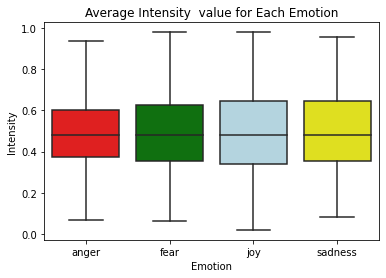

In [10]:
# Observing the  average intensity of each emotion
colors = ['red', 'green', 'lightblue', 'yellow']
bplot = sns.boxplot(data  = train_data, x='Emotion', y='Intensity', palette = colors)
plt.title('Average Intensity  value for Each Emotion')

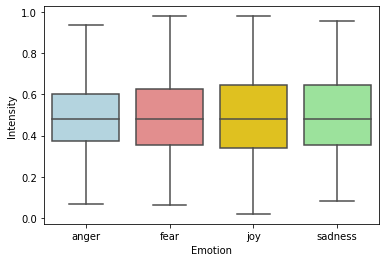

In [11]:
# Defining custom colors for each emotion
colors = {'anger': 'lightblue', 'fear': 'lightcoral', 'joy': 'gold', 'sadness': 'lightgreen'}

# Create a boxplot
bplot = sns.boxplot(data=train_data, x='Emotion', y='Intensity', palette=colors.values())

In [12]:
join_text_fear = ','.join(train_data[train_data['Emotion'] == 'fear']['Text'].values)
join_text_angry = ','.join(train_data[train_data['Emotion'] == 'anger']['Text'].values)
join_text_joy = ','.join(train_data[train_data['Emotion'] == 'joy']['Text'].values)
join_text_sadness = ','.join(train_data[train_data['Emotion'] == 'sadness']['Text'].values)

In [13]:
join_text_angry[:600]

"How the fu*k! Who the heck! moved my fridge!... should I knock the landlord door. #angry #mad ##,So my Indian Uber driver just called someone the N word. If I wasn't in a moving vehicle I'd have jumped out #disgusted ,@DPD_UK I asked for my parcel to be delivered to a pick up store not my address #fuming #poorcustomerservice,so ef whichever butt wipe pulled the fire alarm in davis bc I was sound asleep #pissed #angry #upset #tired #sad #tired #hangry ######,Don't join @BTCare they put the phone down on you, talk over you and are rude. Taking money out of my acc willynilly! #fuming,My blood is "

In [14]:
fear_counter = Counter(word for word in join_text_fear.split(' ') if word != '' and word[0]=='#')
most_common = fear_counter.most_common(12)
hashtags1, totals1 = zip(*most_common)

angry_counter = Counter(word for word in join_text_angry.split(' ') if word != '' and word[0]=='#')
most_common = angry_counter.most_common(10)
hashtags2, totals2 = zip(*most_common)

joy_counter = Counter(word for word in join_text_joy.split(' ') if word != '' and word[0]=='#')
most_common = joy_counter.most_common(10)
hashtags3, totals3 = zip(*most_common)

sadness_counter = Counter(word for word in join_text_sadness.split(' ') if word != '' and word[0]=='#')
most_common = sadness_counter.most_common(10)
hashtags4, totals4 = zip(*most_common)

Text(0.5, 1.0, '10 Most Used Hashtags for Sadness')

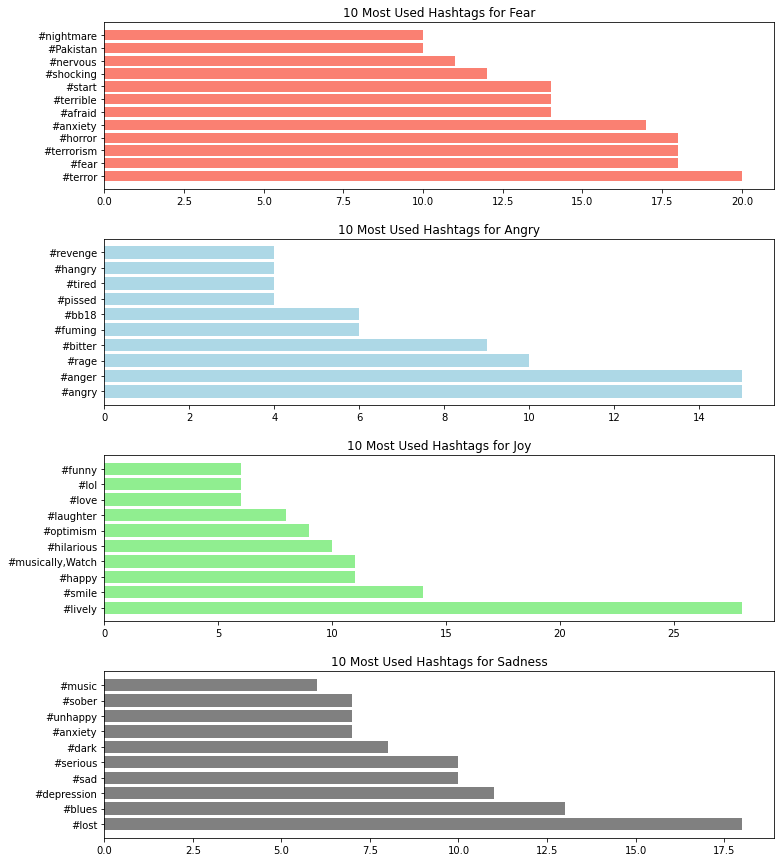

In [15]:
# visualizing the 10 most common hashtags for the emotions.
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 15))
fig.subplots_adjust(hspace= 0.3)

# Plot the barh directly

ax1.barh(hashtags1, totals1, color="salmon")
ax1.set_title("10 Most Used Hashtags for Fear")


ax2.barh(hashtags2, totals2, color="lightblue")
ax2.set_title("10 Most Used Hashtags for Angry")


ax3.barh(hashtags3, totals3, color="lightgreen")
ax3.set_title("10 Most Used Hashtags for Joy")

ax4.barh(hashtags4, totals4, color="grey")
ax4.set_title("10 Most Used Hashtags for Sadness")


In [16]:
# Define stopwords (common words to be excluded from the word cloud)
stopwords = set(STOPWORDS)

# Generation of word clouds for each emotion with specific settings
wordcloud_fear = WordCloud(
    max_font_size=30,          # Maximum font size for words
    background_color='lightpink',  # Background color of the word cloud
    stopwords=stopwords,       # Set of stopwords to exclude
    width=900, height=400       # Width and height of the word cloud image
).generate(join_text_fear)

wordcloud_angry = WordCloud(
    max_font_size=50,
    background_color='lightcoral',
    stopwords=stopwords,
    width=900, height=400
).generate(join_text_angry)

wordcloud_joy = WordCloud(
    max_font_size=50,
    background_color='lightyellow',
    stopwords=stopwords,
    width=900, height=400
).generate(join_text_joy)

wordcloud_sadness = WordCloud(
    max_font_size=50,
    background_color='lightblue',
    stopwords=stopwords,
    width=900, height=400
).generate(join_text_sadness)

(-0.5, 899.5, 399.5, -0.5)

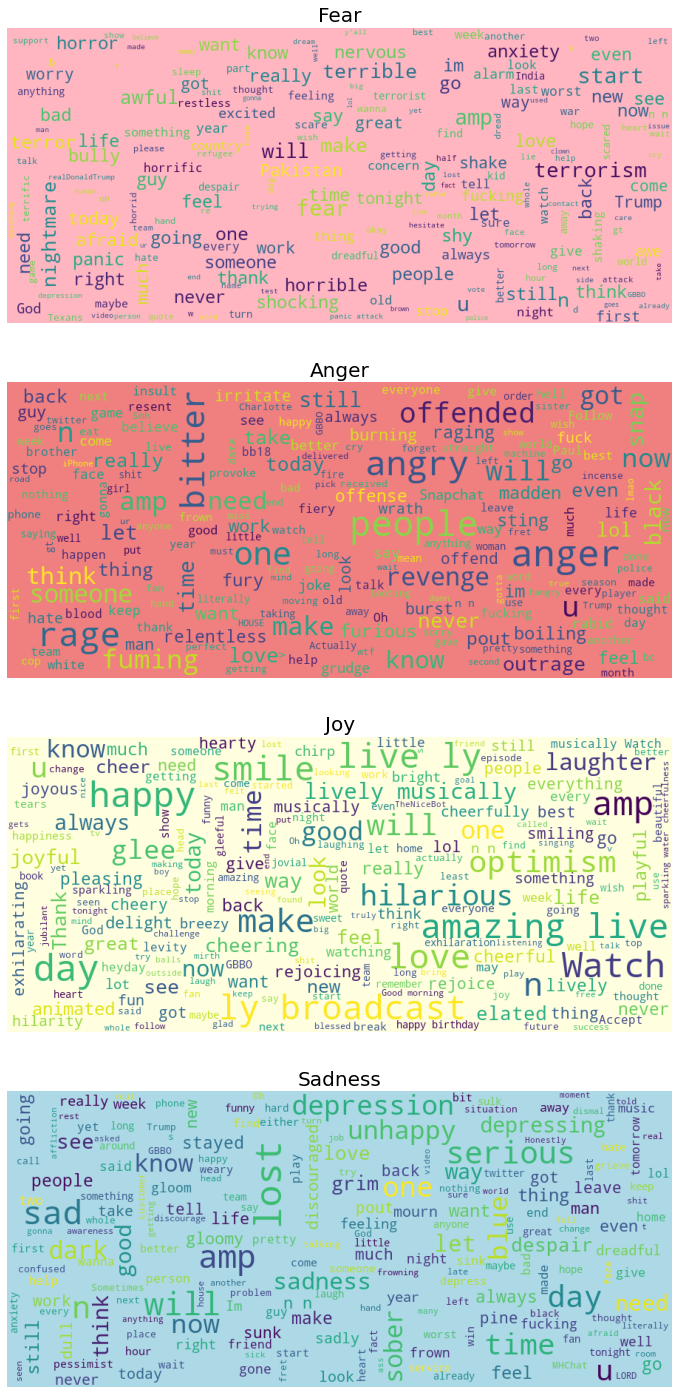

In [17]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(25, 25))

ax1.imshow(wordcloud_fear)
ax1.set_title("Fear", size=20)
ax1.axis('off')

ax2.imshow(wordcloud_angry)
ax2.set_title("Anger", size=20)
ax2.axis('off')

ax3.imshow(wordcloud_joy)
ax3.set_title("Joy", size=20)
ax3.axis('off')

ax4.imshow(wordcloud_sadness)
ax4.set_title("Sadness", size=20)
ax4.axis('off')

In [18]:
stop_words = get_stop_words('en')
train_data = text_cleaning(train_data)

In [19]:
train_data.head(4)

,ID,Text,Emotion,Intensity
0,10000,fu * k ! heck ! moved fridge ! ... knock landl...,anger,0.938
1,10001,indian uber driver just called someone n word ...,anger,0.896
2,10002,asked parcel delivered pick store address # fu...,anger,0.896
3,10003,ef whichever butt wipe pulled fire alarm davis...,anger,0.896


In [20]:
testing_data = combine_data('development/with_intensity')
testing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 347 entries, 0 to 346
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         347 non-null    int64  
 1   Text       347 non-null    object 
 2   Emotion    347 non-null    object 
 3   Intensity  347 non-null    float64
dtypes: float64(1), int64(1), object(2)
memory usage: 11.0+ KB


In [21]:
testing_data = text_cleaning(testing_data)
testing_data.head()

,ID,Text,Emotion,Intensity
0,10857,pls dont insult word 'molna ',anger,0.479
1,10858,almost took offense actually snapped,anger,0.458
2,10859,rutgers game abomination . affront god man . m...,anger,0.562
3,10860,"'s lisa asked started raging , 'can call ? ' heh",anger,0.500
4,10861,sometimes get mad something minuscule try ruin...,anger,0.708


# Using Training data to train the model and dev data to testing.

In [22]:

Emotion = pd.get_dummies(train_data['Emotion'])

# Applying Bag of Words (BoW) Technique
vectorizer = CountVectorizer(max_features=1000, ngram_range=(1, 3))
train_BoW = vectorizer.fit_transform(train_data.Text)
train_BoW = hstack([train_BoW, Emotion.values])

# Applying TF-IDF Technique
vectorizer_tfidf = TfidfVectorizer(max_features=1000)
train_tfidf = vectorizer_tfidf.fit_transform(train_data.Text)
train_tfidf = hstack([train_tfidf, Emotion.values])


In [23]:
train_tfidf.shape

(3613, 1004)

In [24]:
# using Linear regression algorithm.
BoW_linreg = LinearRegression().fit(train_BoW, train_data['Intensity'])
tfidf_linreg = LinearRegression().fit(train_tfidf, train_data['Intensity'])

In [25]:
#Using Ridge Regression
BoW_ridge = Ridge().fit(train_BoW, train_data['Intensity'])
tfidf_ridge = Ridge().fit(train_tfidf, train_data['Intensity'])

In [26]:
#Using Knn Regression
n_neighbors=5
BoW_knn = KNeighborsRegressor(n_neighbors,weights='uniform').fit(train_BoW, train_data['Intensity'])
tfidf_knn = KNeighborsRegressor(n_neighbors,weights='uniform').fit(train_tfidf, train_data['Intensity'])

In [27]:
#Using Decision Tree Regression
BoW_tree = tree.DecisionTreeRegressor(max_depth=1).fit(train_BoW, train_data['Intensity'])
tfidf_tree = tree.DecisionTreeRegressor(max_depth=1).fit(train_tfidf, train_data['Intensity'])

In [28]:
#Using Support Vector Regression
BoW_svr = svm.SVR().fit(train_BoW, train_data['Intensity'])
tfidf_svr = svm.SVR().fit(train_tfidf, train_data['Intensity'])

In [29]:
# Data for testing
Emotion = pd.get_dummies(testing_data['Emotion'])

# Applying Bag of Words (BoW) Technique
vectorizer = CountVectorizer(max_features=1000, ngram_range=(1, 3))
test_BoW = vectorizer.fit_transform(testing_data.Text)
test_BoW = hstack([test_BoW, Emotion.values])

# Applying TF-IDF Technique
vectorizer_tfidf = TfidfVectorizer(max_features=1000)
test_tfidf = vectorizer_tfidf.fit_transform(testing_data.Text)
test_tfidf = hstack([test_tfidf, Emotion.values])

In [30]:
get_score(testing_data['Intensity'], BoW_linreg.predict(test_BoW), "BoW-Linear Regression")
get_score(testing_data['Intensity'], tfidf_linreg.predict(test_tfidf), "Tfidf-Linear Regression")

get_score(testing_data['Intensity'], BoW_ridge.predict(test_BoW), "BoW-Ridge Regression")
get_score(testing_data['Intensity'], tfidf_ridge.predict(test_tfidf), "Tfidf-Ridge Regression")

get_score(testing_data['Intensity'], BoW_knn.predict(test_BoW), "BoW-Knn Regression")
get_score(testing_data['Intensity'], tfidf_knn.predict(test_tfidf), "Tfidf-Knn Regression")

get_score(testing_data['Intensity'], BoW_tree.predict(test_BoW), "BoW-Decision Tree Regression")
get_score(testing_data['Intensity'], tfidf_tree.predict(test_tfidf), "Tfidf-Decision Tree Regression")

get_score(testing_data['Intensity'], BoW_svr.predict(test_BoW), "BoW-SVR")
get_score(testing_data['Intensity'], tfidf_svr.predict(test_tfidf), "Tfidf-SVR")

BoW-Linear Regression

Mean Absolute Error: 0.21539518836125898
Mean Squared Error: 0.07526936985636251
Root Mean Squared Error: 0.2743526377791227
-------------------------------------------------------------------------------
Tfidf-Linear Regression

Mean Absolute Error: 0.2033318574365289
Mean Squared Error: 0.0671364932056381
Root Mean Squared Error: 0.25910710759382516
-------------------------------------------------------------------------------
BoW-Ridge Regression

Mean Absolute Error: 0.1955341412005601
Mean Squared Error: 0.06064577574682932
Root Mean Squared Error: 0.24626363058078496
-------------------------------------------------------------------------------
Tfidf-Ridge Regression

Mean Absolute Error: 0.17022741279480064
Mean Squared Error: 0.04678366984802134
Root Mean Squared Error: 0.21629533015768357
-------------------------------------------------------------------------------
BoW-Knn Regression

Mean Absolute Error: 0.17366916426512968
Mean Squared Error: 0.046

In [31]:
y_actual = testing_data['Intensity']
y_predicted = tfidf_svr.predict(test_tfidf)

pd.DataFrame(data={"Actual Intensity" : testing_data['Intensity'], "Predicted Intensity" : tfidf_svr.predict(test_tfidf)})

,Actual Intensity,Predicted Intensity
0,0.479,0.454469
1,0.458,0.491837
2,0.562,0.546791
3,0.500,0.539575
4,0.708,0.525230
...,...,...
342,0.833,0.476449
343,0.688,0.454822
344,0.458,0.449018
345,0.333,0.566173


In [32]:
y_actual1 = testing_data['Intensity']
y_predicted1 = tfidf_ridge.predict(test_tfidf)


pd.DataFrame(data={"Actual Intensity" : testing_data['Intensity'], "Predicted Intensity" : tfidf_svr.predict(test_tfidf)})

,Actual Intensity,Predicted Intensity
0,0.479,0.454469
1,0.458,0.491837
2,0.562,0.546791
3,0.500,0.539575
4,0.708,0.525230
...,...,...
342,0.833,0.476449
343,0.688,0.454822
344,0.458,0.449018
345,0.333,0.566173


visualizing how well the predicted values align with the actual values.points cluster around the regression line, it suggests a good linear relationship between the actual and predicted values. 

C:\Users\obles\AppData\Roaming\Python\Python310\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Predicted Intensity')

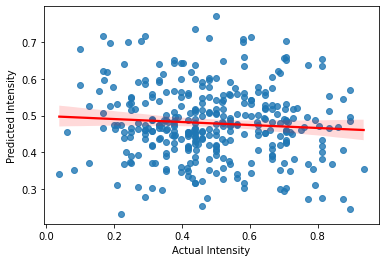

In [33]:
sns.regplot(y_actual1, y_predicted1, line_kws={'color':'red'})
plt.xlabel("Actual Intensity")
plt.ylabel("Predicted Intensity")

Text(0, 0.5, 'Predicted Intensity')

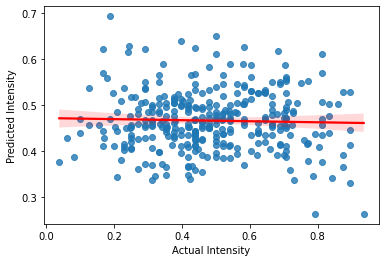

In [34]:
#Plotting distribution of actual intensity to the predicted intensity
sns.regplot(y_actual, y_predicted, line_kws={'color':'red'})
plt.xlabel("Actual Intensity")
plt.ylabel("Predicted Intensity")

In [35]:
#Training the final model with the combination of training and development data
# Concatenate the two DataFrames along the rows (axis=0)
combined_data_for_training = pd.concat([train_data, testing_data], axis=0)

# If the indices need to be reset
combined_data_for_training.reset_index(drop=True, inplace=True)

In [36]:
combined_data_for_training.shape

(3960, 4)

In [37]:
combined_data_for_training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3960 entries, 0 to 3959
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         3960 non-null   int64  
 1   Text       3960 non-null   object 
 2   Emotion    3960 non-null   object 
 3   Intensity  3960 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 123.9+ KB


In [38]:
# Separate model for each emotion.
combined_vectorizer = TfidfVectorizer(max_features=1000)

# ANGER
anger_data = combined_data_for_training.loc[combined_data_for_training['Emotion'] == 'anger']
X_anger = combined_vectorizer.fit_transform(anger_data['Text'])
y_anger = anger_data['Intensity']
anger_model = svm.SVR().fit(X_anger, y_anger)

# FEAR
fear_data = combined_data_for_training.loc[combined_data_for_training['Emotion'] == 'fear']
X_fear = combined_vectorizer.fit_transform(fear_data['Text'])
y_fear = fear_data['Intensity']
fear_model = svm.SVR().fit(X_fear, y_fear)

# SADNESS
sad_data = combined_data_for_training.loc[combined_data_for_training['Emotion'] == 'sadness']
X_sad = combined_vectorizer.fit_transform(sad_data['Text'])
y_sad = sad_data['Intensity']
sad_model = svm.SVR().fit(X_sad, y_sad)

# JOY
joy_data = combined_data_for_training.loc[combined_data_for_training['Emotion'] == 'joy']
X_joy = combined_vectorizer.fit_transform(joy_data['Text'])
y_joy = joy_data['Intensity']
joy_model = svm.SVR().fit(X_joy, y_joy)

In [39]:
# testing data
data_for_testing = combine_data('test/with_intensity')
data_for_testing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3142 entries, 0 to 3141
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         3142 non-null   int64  
 1   Text       3142 non-null   object 
 2   Emotion    3142 non-null   object 
 3   Intensity  3142 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 98.3+ KB


In [40]:
data_for_testing = text_cleaning(data_for_testing)
data_for_testing['Emotion'].value_counts()

fear       995
anger      760
joy        714
sadness    673
Name: Emotion, dtype: int64

In [41]:
grouped_df = data_for_testing.groupby('Emotion')

# Creating separate DataFrames for each group
emotion_dfs = {emotion: group for emotion, group in grouped_df}

# Accessing separate DataFrames for each emotion
joy_df = emotion_dfs.get('joy', pd.DataFrame())
fear_df = emotion_dfs.get('fear', pd.DataFrame())
anger_df = emotion_dfs.get('anger', pd.DataFrame())
sad_df = emotion_dfs.get('sadness', pd.DataFrame())

In [42]:
joy_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 714 entries, 1755 to 2468
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         714 non-null    int64  
 1   Text       714 non-null    object 
 2   Emotion    714 non-null    object 
 3   Intensity  714 non-null    float64
dtypes: float64(1), int64(1), object(2)
memory usage: 27.9+ KB


In [43]:
fear_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 995 entries, 760 to 1754
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         995 non-null    int64  
 1   Text       995 non-null    object 
 2   Emotion    995 non-null    object 
 3   Intensity  995 non-null    float64
dtypes: float64(1), int64(1), object(2)
memory usage: 38.9+ KB


In [44]:
anger_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 760 entries, 0 to 759
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         760 non-null    int64  
 1   Text       760 non-null    object 
 2   Emotion    760 non-null    object 
 3   Intensity  760 non-null    float64
dtypes: float64(1), int64(1), object(2)
memory usage: 29.7+ KB


In [45]:
sad_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 673 entries, 2469 to 3141
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         673 non-null    int64  
 1   Text       673 non-null    object 
 2   Emotion    673 non-null    object 
 3   Intensity  673 non-null    float64
dtypes: float64(1), int64(1), object(2)
memory usage: 26.3+ KB


In [46]:
joy_df = text_cleaning(joy_df)
fear_df = text_cleaning(fear_df)
anger_df = text_cleaning(anger_df)
sad_df = text_cleaning(sad_df)

In [47]:
# Apply the function to each emotion DataFrame
Y_joy_actual, Y_joy_predicted = predict_emotion_intensity(joy_model, combined_vectorizer, joy_df, 'Intensity')
Y_fear_actual, Y_fear_predicted = predict_emotion_intensity(fear_model, combined_vectorizer, fear_df, 'Intensity')
Y_anger_actual, Y_anger_predicted = predict_emotion_intensity(anger_model, combined_vectorizer, anger_df, 'Intensity')
Y_sad_actual, Y_sad_predicted = predict_emotion_intensity(sad_model, combined_vectorizer, sad_df, 'Intensity')

# Now we have the actual and predicted values for each emotion in separate variables

In [48]:
Y_joy_actual

1755    0.583
1756    0.500
1757    0.860
1758    0.521
1759    0.042
        ...  
2464    0.417
2465    0.146
2466    0.646
2467    0.620
2468    0.580
Name: Intensity, Length: 714, dtype: float64

In [49]:
Y_joy_predicted[:4]

array([0.54605283, 0.49255282, 0.59380763, 0.35350341])

C:\Users\obles\AppData\Roaming\Python\Python310\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


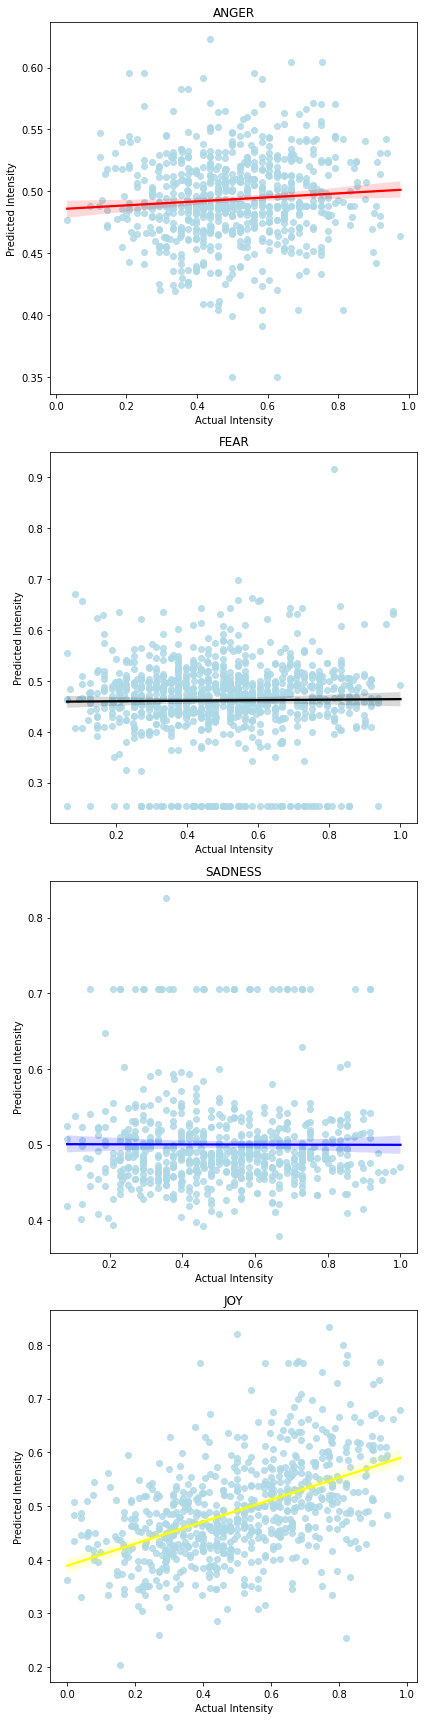

In [50]:
# Apply the function to each emotion DataFrame
Y_joy_actual, Y_joy_predicted = predict_emotion_intensity(joy_model, combined_vectorizer, joy_df, 'Intensity')
Y_fear_actual, Y_fear_predicted = predict_emotion_intensity(fear_model, combined_vectorizer, fear_df, 'Intensity')
Y_anger_actual, Y_anger_predicted = predict_emotion_intensity(anger_model, combined_vectorizer, anger_df, 'Intensity')
Y_sad_actual, Y_sad_predicted = predict_emotion_intensity(sad_model, combined_vectorizer, sad_df, 'Intensity')

# Visualize the results
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(6, 24))

# ANGER
sns.regplot(Y_anger_actual, Y_anger_predicted, ax=ax1, line_kws={'color':'red'}, scatter_kws={"color": "lightblue"})
ax1.set_xlabel("Actual Intensity")
ax1.set_ylabel("Predicted Intensity")
ax1.set_title("ANGER")

# FEAR
sns.regplot(Y_fear_actual, Y_fear_predicted, ax=ax2, line_kws={'color':'black'}, scatter_kws={"color": "lightblue"})
ax2.set_xlabel("Actual Intensity")
ax2.set_ylabel("Predicted Intensity")
ax2.set_title("FEAR")

# SADNESS
sns.regplot(Y_sad_actual, Y_sad_predicted, ax=ax3, line_kws={'color':'blue'}, scatter_kws={"color": "lightblue"})
ax3.set_xlabel("Actual Intensity")
ax3.set_ylabel("Predicted Intensity")
ax3.set_title("SADNESS")

# JOY
sns.regplot(Y_joy_actual, Y_joy_predicted, ax=ax4, line_kws={'color':'yellow'}, scatter_kws={"color": "lightblue"})
ax4.set_xlabel("Actual Intensity")
ax4.set_ylabel("Predicted Intensity")
ax4.set_title("JOY")

plt.tight_layout()
plt.show()


In [51]:
get_score(Y_anger_actual, Y_anger_predicted, "Result of Anger Model")
get_score(Y_fear_actual, Y_fear_predicted, "Result of Fear Model")
get_score(Y_sad_actual, Y_sad_predicted, "Result of Sadness Model")
get_score(Y_joy_actual, Y_joy_predicted, "Result of Joy Model")

Result of Anger Model

Mean Absolute Error: 0.13981301338285698
Mean Squared Error: 0.029775357657916363
Root Mean Squared Error: 0.1725553756274094
-------------------------------------------------------------------------------
Result of Fear Model

Mean Absolute Error: 0.17812656473619445
Mean Squared Error: 0.047988711278757396
Root Mean Squared Error: 0.219063258623525
-------------------------------------------------------------------------------
Result of Sadness Model

Mean Absolute Error: 0.17597864954173914
Mean Squared Error: 0.04502715217915758
Root Mean Squared Error: 0.21219602300504498
-------------------------------------------------------------------------------
Result of Joy Model

Mean Absolute Error: 0.15553479537387555
Mean Squared Error: 0.03637473681709938
Root Mean Squared Error: 0.19072162126276973
-------------------------------------------------------------------------------


In [52]:
pear_results = []
pear_results_range_05_1 = []

num_pairs = 4
emotion_names = ["Anger", "Fear", "Sad", "Joy"]
actual_predicted_pairs = [
    (Y_anger_actual, Y_anger_predicted),
    (Y_fear_actual, Y_fear_predicted),
    (Y_sad_actual, Y_sad_predicted),
    (Y_joy_actual, Y_joy_predicted)
]


In [53]:
# Loop through emotion pairs
for i in range(num_pairs):
    name_actual = f"{emotion_names[i]}_Actual"
    name_predicted = f"{emotion_names[i]}_Predicted"
    actual, predicted = actual_predicted_pairs[i]

    result = evaluate(predicted, actual)

    print(f"Pearson correlation between {name_predicted} and {name_actual}:\t{result[0]}")
    pear_results.append(result[0])

    print(f"Pearson correlation for actual scores in range 0.5-1 between {name_predicted} and {name_actual}:\t{result[1]}")
    pear_results_range_05_1.append(result[1])

Pearson correlation between Anger_Predicted and Anger_Actual:	0.08168875235839007
Pearson correlation for actual scores in range 0.5-1 between Anger_Predicted and Anger_Actual:	0.07968867339947143
Pearson correlation between Fear_Predicted and Fear_Actual:	0.013063134600042506
Pearson correlation for actual scores in range 0.5-1 between Fear_Predicted and Fear_Actual:	-0.0011435159038527
Pearson correlation between Sad_Predicted and Sad_Actual:	-0.003003835992153488
Pearson correlation for actual scores in range 0.5-1 between Sad_Predicted and Sad_Actual:	0.0011031579332264137
Pearson correlation between Joy_Predicted and Joy_Actual:	0.4885325446532532
Pearson correlation for actual scores in range 0.5-1 between Joy_Predicted and Joy_Actual:	0.29985315758500886


In [54]:
avg_pear = np.mean(pear_results)
avg_pear_range_05_1 = np.mean(pear_results_range_05_1)

print(f"Average Pearson correlation:\t{avg_pear}")
print(f"Average Pearson correlation for actual scores in range 0.5-1:\t{avg_pear_range_05_1}")


Average Pearson correlation:	0.14507014890488307
Average Pearson correlation for actual scores in range 0.5-1:	0.0948753682534635
